In [1]:
import pandas as pd
%matplotlib inline

# Data Cleaning

In [2]:
all_complaints = pd.read_csv('data/DOB_Complaints_Received.csv')
print(list(all_complaints))
print(len(all_complaints))

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['Complaint Number', 'Status', 'Date Entered', 'House Number', 'ZIP Code', 'House Street', 'BIN', 'Community Board', 'Special District', 'Complaint Category', 'Unit', 'Disposition Date', 'Disposition Code', 'Inspection Date', 'DOBRunDate']
2303002


### Handle types

In [3]:
all_complaints['Complaint Category'] = all_complaints['Complaint Category'].astype(str)

### Filter down to just Boilers

In [4]:
complaint_categories = ['58']

boiler_complaints = all_complaints[all_complaints['Complaint Category'].isin(complaint_categories)]

print("Number of total complaints: {}".format(len(all_complaints)))
print("Number of boiler complaints: {}".format(len(boiler_complaints)))

boiler_complaints['Complaint Category'].value_counts()

Number of total complaints: 2303002
Number of boiler complaints: 29798


58    29798
Name: Complaint Category, dtype: int64

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


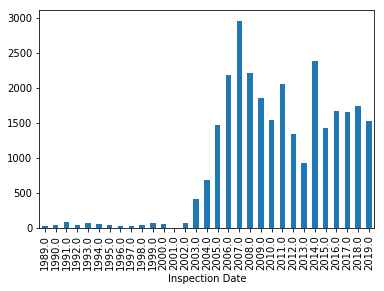

In [5]:
boiler_complaints['Inspection Date'] = pd.to_datetime(boiler_complaints['Inspection Date'])
boiler_complaints.groupby(boiler_complaints['Inspection Date'].dt.year).count()['BIN'].plot(kind='bar')

### Remove Duplicates

In [6]:
boiler_complaints = boiler_complaints.drop_duplicates(subset=['BIN', 'Date Entered'])
print("number of boiler complaints after dropping duplicates: {}".format(len(boiler_complaints)))

number of boiler complaints after dropping duplicates: 27716


### Filter down to relevant labels

I2    7984
C2    7479
A8    5094
A1    3987
H1    1072
      1042
I1     344
C4     176
B1     116
F8      93
A9      83
K1      52
C1      40
L2      27
D6      24
ND      20
F1      18
K2      10
G6      10
B2       6
G8       6
D2       5
F3       5
F6       3
L1       3
A3       2
Y3       2
H2       2
A6       2
H5       1
G4       1
P5       1
Y2       1
J1       1
H4       1
F5       1
H3       1
C3       1
Name: Disposition Code, dtype: int64


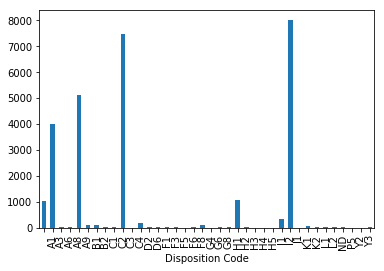

In [7]:
print(boiler_complaints['Disposition Code'].value_counts())
boiler_complaints.groupby('Disposition Code').count()['BIN'].plot('bar')

**Positive**: A8 (ECB Violation Served), A1 (Buildings Violation(s) Served), B1 (Buildings Violation(s) Prepared and Attempt to Serve will be Made)

**Negative**: I2 (No Violation Warranted for Complaint at Time of Inspection), I1 (Complaint Unsubstantiated Based on Department Records), 

**Note**: C2 (Inspector Unable to Gain Access – Final Attempt) did not include to assume we could gain access to the building.  It kind of seems like that would be a different classification task

In [8]:
positive_labels = ['A1', 'A8', 'B1']
negative_labels = ['I1', 'I2']
boiler_complaints = boiler_complaints[boiler_complaints['Disposition Code'].isin(positive_labels + negative_labels)]
print("Number of complaints after filter down to relevant dispoisition codes: {}".format(len(boiler_complaints)))

Number of complaints after filter down to relevant dispoisition codes: 17525


# Create Labels

In [9]:
labels = boiler_complaints['Disposition Code'].isin(positive_labels) * 1

In [10]:
print("Percent of labels that are positive (result in violation): {}".format(sum(labels) / len(labels)))

Percent of labels that are positive (result in violation): 0.524793152639087


# Create Features

In [11]:
features = pd.DataFrame()
features['Violation'] = labels
boiler_complaints['Violation'] = labels
features.head()

,Violation
2082,1
2083,0
2084,1
2094,0
2883,0


In [12]:
def violation_ratio_test(column):
    return features.groupby(column)['Violation'].sum() / features.groupby(column).count()['Violation']

### Boiler Category / Priority

In [13]:
boiler_complaints['Complaint Category'].value_counts()

58    17525
Name: Complaint Category, dtype: int64

In [14]:
boiler_complaints['Complaint Category'] = boiler_complaints['Complaint Category'].astype('category')
boiler_complaints['Complaint Category'] = boiler_complaints['Complaint Category'].cat.codes
features['Complaint Category'] = boiler_complaints['Complaint Category']

In [15]:
violation_ratio_test('Complaint Category')

Complaint Category
0    0.524793
Name: Violation, dtype: float64

### Number of previous boiler complaints

In [16]:
def get_previous_complaints(row):
    # Get all of complaings with same BIN
    # remove complaints with same complaint number
    # get total of violation (could even do violation ratio)
    bin_complaints = boiler_complaints[boiler_complaints['BIN'] == row['BIN']]
    bin_complaints = bin_complaints[boiler_complaints['Complaint Number'] != row['Complaint Number']]
    return len(bin_complaints)

In [17]:
features['Previous Complaints'] = boiler_complaints.apply(get_previous_complaints, axis=1 )

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [18]:
features['Previous Complaints'].value_counts()

0     9125
1     3262
2     1638
3      836
4      505
5      312
6      308
7      200
9      170
8      135
10     132
13      98
40      82
14      75
73      74
22      69
66      67
12      65
11      60
51      52
16      51
19      40
36      37
17      36
26      27
25      26
21      22
20      21
Name: Previous Complaints, dtype: int64

In [19]:
violation_ratio_test('Previous Complaints')

Previous Complaints
0     0.543562
1     0.532189
2     0.559829
3     0.531100
4     0.499010
5     0.500000
6     0.542208
7     0.340000
8     0.503704
9     0.441176
10    0.416667
11    0.300000
12    0.523077
13    0.285714
14    0.440000
16    0.254902
17    0.222222
19    0.400000
20    0.047619
21    0.636364
22    0.492754
25    0.346154
26    0.296296
36    0.216216
40    0.256098
51    0.326923
66    0.283582
73    0.243243
Name: Violation, dtype: float64

In [20]:
# The less previous complaints a building has, the more likely it is the complaint will result in a violation

In [21]:
# Checking to make sure these aren't duplicate 
boiler_complaints[boiler_complaints['BIN'] == 1015102]

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,Unit,Disposition Date,Disposition Code,Inspection Date,DOBRunDate,Violation
127622,1134056,CLOSED,12/19/2004,139,10001,WEST 28 STREET,1015102,105,,0,BOILR,01/24/2005,I2,2005-01-18,11/07/2018 12:00:00 AM,0
181203,1190768,CLOSED,04/10/2007,139,10001,WEST 28 STREET,1015102,105,,0,BOILR,05/04/2007,A1,2007-04-27,11/07/2018 12:00:00 AM,1


### Number of previous boiler violations
TODO: might be better for this to come from the DOB Violation dataset?

Make sure current complaint is not included in the number of previous violations! (This would include the label in the features... yikes man)

In [22]:
def get_previous_violations(row):
    # Get all of complaings with same BIN
    # remove complaints with same complaint number
    # get total of violation (could even do violation ratio)
    bin_complaints = boiler_complaints[boiler_complaints['BIN'] == row['BIN']]
    bin_complaints = bin_complaints[bin_complaints['Violation'] == 1]
    bin_complaints = bin_complaints[boiler_complaints['Complaint Number'] != row['Complaint Number']]
    return len(bin_complaints)

In [23]:
# # get_previous_violations test
# for row in boiler_complaints.iterrows():
#     num_previous_complaints = get_previous_violations(row[1])
#     print(num_previous_complaints)
# #     break

In [24]:
features['Previous Violations'] = boiler_complaints.apply(get_previous_violations, axis=1 )

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [25]:
features['Previous Violations'].value_counts()

0     11411
1      2903
2      1282
3       644
4       342
5       231
6       151
8       120
18       98
7        95
17       71
19       48
9        47
13       28
21       22
16       17
14       14
22        1
Name: Previous Violations, dtype: int64

In [26]:
violation_ratio_test('Previous Violations')

Previous Violations
0     0.512225
1     0.542198
2     0.641186
3     0.478261
4     0.599415
5     0.597403
6     0.463576
7     0.421053
8     0.525000
9     0.212766
13    1.000000
14    0.000000
16    1.000000
17    0.507042
18    0.193878
19    0.000000
21    1.000000
22    0.000000
Name: Violation, dtype: float64

### Number of previous boiler violations / complaints ratio

In [27]:
features['Violation Ratio'] = (features['Previous Violations'] / features['Previous Complaints']).fillna(0)
features.head()

,Violation,Complaint Category,Previous Complaints,Previous Violations,Violation Ratio
2082,1,0,0,0,0.000000
2083,0,0,3,2,0.666667
2084,1,0,0,0,0.000000
2094,0,0,0,0,0.000000
2883,0,0,1,1,1.000000


In [28]:
print(features['Violation Ratio'].value_counts())
violation_ratio_test('Violation Ratio')

0.000000    11411
1.000000     2679
0.500000      922
0.666667      416
0.333333      282
0.250000      156
0.750000      135
0.200000       90
0.600000       88
0.428571       72
0.285714       62
0.800000       61
0.400000       59
0.246575       56
0.222222       51
0.272727       48
0.287879       48
0.142857       47
0.833333       44
0.075000       38
0.375000       33
0.076923       28
0.444444       27
0.125000       27
0.571429       26
0.307692       24
0.050000       23
0.450000       23
0.625000       22
0.954545       22
            ...  
0.888889       11
0.181818       11
0.230769       11
0.777778       11
0.437500       10
0.714286        9
0.857143        9
0.615385        9
0.384615        9
0.320000        9
0.700000        8
0.363636        8
0.636364        8
0.269231        8
0.194444        8
0.461538        7
0.538462        7
0.642857        6
0.736842        6
0.416667        6
0.294118        6
0.583333        6
0.692308        5
0.727273        4
0.187500  

Violation Ratio
0.000000    0.512225
0.050000    0.130435
0.052632    1.000000
0.058824    1.000000
0.062500    1.000000
0.075000    0.000000
0.076923    0.071429
0.100000    1.000000
0.105263    0.000000
0.111111    0.181818
0.117647    0.000000
0.125000    0.148148
0.142857    0.255319
0.153846    0.200000
0.166667    0.368421
0.181818    1.000000
0.187500    1.000000
0.194444    1.000000
0.200000    0.177778
0.222222    0.117647
0.227273    0.000000
0.230769    0.000000
0.232877    1.000000
0.246575    0.000000
0.250000    0.301282
0.269231    1.000000
0.272727    0.625000
0.285714    0.419355
0.287879    0.000000
0.294118    1.000000
              ...   
0.444444    0.555556
0.450000    0.000000
0.461538    1.000000
0.500000    0.544469
0.538462    0.000000
0.555556    0.285714
0.571429    0.538462
0.583333    0.000000
0.600000    0.409091
0.615385    1.000000
0.619048    1.000000
0.625000    0.818182
0.636364    1.000000
0.642857    0.000000
0.666667    0.706731
0.684211    1.0000

In [29]:
features['ZIP Code'] = boiler_complaints['ZIP Code'].astype('category').cat.codes
features.head()

,Violation,Complaint Category,Previous Complaints,Previous Violations,Violation Ratio,ZIP Code
2082,1,0,0,0,0.000000,64
2083,0,0,3,2,0.666667,72
2084,1,0,0,0,0.000000,49
2094,0,0,0,0,0.000000,83
2883,0,0,1,1,1.000000,70


# Boiler make

In [30]:
boiler_inspections = pd.read_csv('data/DOB_NOW_Boiler_Safety.csv')
list(boiler_inspections)

FileNotFoundError: [Errno 2] File b'data/DOB_NOW_Boiler_Safety.csv' does not exist: b'data/DOB_NOW_Boiler_Safety.csv'

### Drop nan Boiler makes

In [ ]:
boiler_features = ['Boiler Make', 'Defects Exist', 'Pressure Type']

print(len(boiler_inspections))
boiler_inspections = boiler_inspections.dropna(subset=boiler_features)
print(len(boiler_inspections))

In [ ]:
print("{} types of models".format(len(set(boiler_inspections['Boiler Model']))))
print("{} types of makes".format(len(set(boiler_inspections['Boiler Make']))))

### Convert to to datetime

In [ ]:
boiler_inspections['Inspection Date'] = pd.to_datetime(boiler_inspections['Inspection Date'])
boiler_inspections['Defects Exist'] = boiler_inspections['Defects Exist'].map({'Yes': 1, 'No':0})

### Clean boiler makes

In [ ]:
from difflib import SequenceMatcher

def similarity(a, b):
#     print(a)
#     print(b)
#     print()
    return SequenceMatcher(None, a, b).ratio()

In [ ]:
print("[similarity()] tests")
print(similarity('LOCH-CERST', 'LOCH-CREST'))
print(similarity('WEIL MCLAIN', 'BEST'))
print(similarity('H B SMITH NEW', 'SMITH    H'))
print()
# create maping of a make to the other spellings
makes = {}

for make in set(boiler_inspections['Boiler Make']):
    # is there something similar in the set of keys? if so put it in the values, if not, create a new key
#     print(f"looking at {make}")
    threshold = 0.6
    found_key = ''
    
    for key in makes.keys():
        sim = similarity(key, make)
        if sim >= threshold:
            found_key = key
            break
        else:
            continue
    
    if found_key != '':
#         print(found_key)
        makes[found_key].append(make)
    else:
        makes[make] = [make]
#     print(makes)

In [ ]:
print(len(makes.keys()))
# invert the mapping
inverted_makes = {}

for make_key, make_values in makes.items():
    for m in make_values:
        inverted_makes[m] = make_key
        
inverted_makes

In [ ]:
# complete the mapping
boiler_inspections['Boiler Make'] = boiler_inspections['Boiler Make'].map(inverted_makes)

### Question: What are the most popular boilers?

In [ ]:
top_makes = boiler_inspections.groupby('Boiler Make').count().sort_values(by='Bin Number', ascending=False)['Tracking Number'].head()
top_makes

### Question: Which boiler makes have the highest rate of defects?

In [ ]:
boiler_make_numerator = boiler_inspections.groupby('Boiler Make').sum()['Defects Exist']

boiler_make_denominator = boiler_inspections.groupby('Boiler Make').count()['Boiler ID']

defect_make_ratio = boiler_make_numerator / boiler_make_denominator

In [ ]:
# of the top 5 boilers, which are the most defective?
for make in top_makes.index:
    print("Make: {} ---- defect ratio: {}".format(make, defect_make_ratio[make]))
    print()

In [ ]:
boiler_inspections.groupby('Bin Number').count()['Tracking Number'].sort_values(ascending=False)

### Bin to boiler features

In [ ]:
def bin_to_boiler(bn):
    """ Returns the most recent boiler information for a given Bin.  None if no records."""
    return boiler_inspections[boiler_inspections['Bin Number'] == bn].sort_values(by='Inspection Date', ascending=False).head(1)

In [ ]:
bin_to_boiler(3071219)

In [ ]:
# TODO: change this to get all relevant boiler features
# boiler_feature_names = ['Pressure Type', 'Boiler Make']

def get_boiler_feature(feature):
    boiler_features = []
    for row in boiler_complaints.iterrows():
        boiler_info = bin_to_boiler(row[1]['BIN'])
        
        boiler_feature = boiler_info[feature].values
#         boiler_features.append(boiler_feature)
        
        if len(boiler_feature) > 0:
            boiler_features.append(boiler_feature[0])
#             print(boiler_feature[0])
    #         print(type(boiler_info))
#             break
        else:
            boiler_features.append(None)
    #         print(len(boiler_features))

#     #     index = boiler_complaints.index[boiler_complaints['BIN'] == row[1]['BIN']].values[0]

    return boiler_features

In [ ]:
features['Boiler Make'] = get_boiler_feature('Boiler Make')
features['Pressure Type'] = get_boiler_feature('Pressure Type')
print(features['Boiler Make'].head())

In [ ]:
features_with_boiler_features = features.dropna(subset=['Boiler Make'])

print("Percent of complaints with boiler features: {}".format(len(features_with_boiler_features) / len(features)))

print("Percent of complaints with boiler features that result in a violation (balance): {}".format(features_with_boiler_features['Violation'].sum() / len(features_with_boiler_features)))

### Get number of previous defects

In [ ]:
bin_to_defects = boiler_inspections.groupby('Bin Number').count()['Defects Exist']
defects_column = []
for row in boiler_complaints.iterrows():
    try:
        defects = bin_to_defects[row[1]['BIN']]
    except:
        defects = None
        
    defects_column.append(defects)

In [ ]:
features['Defects'] = defects_column

In [ ]:
features = features.dropna(subset=['Boiler Make'])
features['Boiler Make'] = features['Boiler Make'].astype('category').cat.codes
features['Pressure Type'] = features['Pressure Type'].astype('category').cat.codes
features.head()

### Question: Why do some complaints not have a BIN in the inspections?
answer: idk

# Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
list(features)

### Create Training and test splits

In [ ]:
y = features['Violation']
X = features[['Violation Ratio', 'ZIP Code', 'Boiler Make', 'Previous Violations', 'Previous Complaints', 'Defects']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=None)

In [ ]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=7, random_state=None)
clf.fit(X_train, y_train)

print(list(X))
print(clf.feature_importances_)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

In [ ]:
# Cross validate

# Split the training data
splits = 5
kf = model_selection.KFold(n_splits = splits)

# Train and fit a random forest on the training data
for train_index, test_index in kf.split(X):
    
    # @TODO Get the right data
    X_train_cross = X.iloc[train_index]
    Y_train_cross = Y.iloc[train_index]
    X_test_cross  = X.iloc[test_index]  
    Y_test_cross  = Y.iloc[test_index]  

    # @TODO Get the right data
    # Convert labels to ints and reshape
    Y_train_len = len(Y_train_cross.values)
    Y_test_len  = len(Y_test_cross.values)
    Y_train_cross = (Y_train_cross.values.reshape(Y_train_len,)).astype('int')
    Y_test_cross  = (Y_test_cross.values.reshape(Y_test_len,)).astype('int')
    
    clf = RandomForestClassifier(n_estimators=1000, max_depth=7, random_state=None)
    clf.fit(X_train_cross, Y_train_cross)

    print(list(X))
    print(clf.feature_importances_)
    print(clf.score(X_train_cross, Y_train_cross))
    print(clf.score(X_test_cross, Y_test_cross))


In [ ]:
# Approximate hyperparams
def approx_hp(depth_vals, num_tree_vals):
    
    for depth in depth_vals:

        for num_trees in num_tree_vals:

            # Define the model 
            clf = RandomForestRegressor(n_estimators = num_trees, max_depth = depth, random_state=None)

            # Train the model
            clf.fit(X_train, y_train)

            # Check results
            print(clf.feature_importances_)
            print(clf.score(X_train, y_train))
            print(clf.score(X_test, y_test))

approx_hp([1, 3, 5, 10, 50, 100], [1, 3, 5, 10, 50, 100])


### Metrics: wooo yaaay

In [ ]:
# Playing with n_estimators and max_depth improves metrics

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC Curve

In [ ]:
y_predict_probs = clf.predict_proba(X_test)
print(clf.classes_)
print(y_predict_probs)

fpr, tpr, thresholds = roc_curve(y_test, y_predict_probs[:,1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, alpha=1,
         label='ROC')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

In [ ]:
# Most confident predictions
sorted(y_predict_probs[:,1])[::-1]